# 1. Setup and Libraries

### 1.1 Installing Important Libraries

In [1]:
!pip install transformers hf_transfer bitsandbytes accelerate openai-whisper ffmpeg jiwer -qU --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 16.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

### 1.2 Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from IPython.display import display, Markdown, HTML, Audio
from tqdm.notebook import tqdm
import requests
from io import BytesIO
from urllib.request import urlopen
import librosa
import requests
import os
import gc
import psutil
import time
import json
import re

from huggingface_hub import login
from jiwer import wer
import transformers
from transformers import Qwen2AudioForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from transformers import pipeline
from transformers import AutoProcessor, AutoModelForCTC

import whisper

from kaggle_secrets import UserSecretsClient

2025-05-27 10:30:18.868277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748341819.062058      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748341819.119412      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1.3 Preparing Static and Environment Variables

In [3]:
user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
BASE_URL = "/kaggle/input/audio-data/audio/audio"

BANKING_PATH = BASE_URL + '/audio_samples/banking/'
INSURANCE_PATH = BASE_URL + "/audio_samples/insurance"
RETAIL_PATH = BASE_URL + "/audio_samples/retail"
TELECOM_PATH = BASE_URL + "/audio_samples/telecom"

DOMAIN_MAP = {'telco': 'telecom'}

In [4]:
env_vars = {
    "GOOGLE_API_KEY":             GOOGLE_API_KEY,
    "HF_TOKEN":                   HF_TOKEN,
    "HF_HUB_ENABLE_HF_TRANSFER":  os.environ.get("HF_HUB_ENABLE_HF_TRANSFER"),
    "BASE_URL":                   BASE_URL,
}

for name, val in env_vars.items():
    if not val:
        raise EnvironmentError(f"{name} is not set or is empty — please configure it before continuing.")

print("✅ All required environment variables are set.")

✅ All required environment variables are set.


In [5]:
try:
    login(token=HF_TOKEN)
    print("✅ Hugging Face login succeeded.")
except Exception as e:
    raise RuntimeError(f"❌ Hugging Face login failed: {e}")

✅ Hugging Face login succeeded.


In [6]:
# - **transcript**: string, the full verbatim transcription of the audio  
# "transcript": "Magandang umaga po. Kailangan ko po ng tulong tungkol sa balanse ng aking savings account.",

In [7]:
SYSTEM_INSTRUCTIONS = """
You are an AI assistant for Contact Center Operations. You will receive a single‐message audio clip—either from a customer or an agent—spoken in English, Filipino, or Taglish. Your job is to extract insights and return **only** a JSON object with the following fields and constraints:

- **language**: one of ["English", "Filipino", "Taglish"]  
- **sentiment**: one of ["Positive", "Neutral", "Negative"]  
- **role**: one of ["customer", "agent"]  
- **case_type**: one of ["Deposits", "Credit Cards", "Loans"]  
- **case_transaction_type**: one of ["Inquiry", "Request", "Complaint"]  
- **case_priority_level**: one of ["Low", "Medium", "High"]  
- **key_themes**: array of strings, the main topics or issues mentioned  
- **actionable_items**: array of strings, concrete next steps or tasks  
- **summary**: string, a brief human-readable synopsis  

Do **not** output any prose outside the JSON. **Only Proper JSON Format**.

### Example:

```json
{
  "language": "Filipino",
  "sentiment": "Neutral",
  "role": "customer",
  "case_type": "Deposits",
  "case_transaction_type": "Inquiry",
  "case_priority_level": "Medium",
  "key_themes": ["account balance", "savings account"],
  "actionable_items": ["Check customer's current balance", "Provide balance details to customer"],
  "summary": "Customer asks for their current savings account balance."
}
"""

### 1.4 Helper Functions

In [8]:
def display_df(df: pd.DataFrame):
    html = df.head(300).to_html(index=False)

    scrollable = f'''
    <div style="
        max-height: 300px;
        max-width: 100%;
        overflow: auto;
        border: 1px solid #ccc;
        white-space: nowrap;
    ">
        {html}
    </div>
    '''

    display(HTML(scrollable))

In [9]:
def get_audio_and_path(df, idx, base_path):
    if 'AudioFile' not in df.columns:
        raise KeyError("DataFrame must contain 'AudioFile'")
    rel_path = df.at[idx, 'AudioFile']
    if base_path.startswith(('http://','https://')):
        full_path = f"{base_path.rstrip('/')}/{rel_path.lstrip('/')}"
        player = Audio(url=full_path)
    else:
        full_path = os.path.join(base_path, rel_path)
        player = Audio(filename=full_path)
    return player, full_path

In [10]:
def visualize_and_clear(model):
    """
    Measures CPU and GPU memory before and after deleting the model
    and clearing caches, then plots a bar chart.
    """
    process = psutil.Process()
    cpu_before = process.memory_info().rss / 1024**2
    gpu_before = torch.cuda.memory_allocated() / 1024**2 if torch.cuda.is_available() else 0

    # Move model to CPU (if applicable) and delete
    try:
        model.to("cpu")
    except Exception:
        pass
    del model
    torch.cuda.empty_cache()
    gc.collect()

    cpu_after = process.memory_info().rss / 1024**2
    gpu_after = torch.cuda.memory_allocated() / 1024**2 if torch.cuda.is_available() else 0

    labels = ["CPU", "GPU"]
    before = [cpu_before, gpu_before]
    after = [cpu_after, gpu_after]
    x = range(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar([i - width/2 for i in x], before, width, label="Before")
    ax.bar([i + width/2 for i in x], after, width, label="After")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Memory (MB)")
    ax.legend()
    plt.show()

In [11]:
def clean(t):
    # 1) strip tags + punctuation
    t = re.sub(r"\[.*?\]", "", t)
    t = re.sub(r"[^\w\s]", "", t)
    t = t.lower()
    # 2) drop filler/pronoun words
    t = re.sub(r"\b(po|ho|ah|um|eh|ko|mo)\b", "", t)
    # 3) collapse pag xxx → pagxxx
    t = re.sub(r"\bpag\s+(\w+)", r"pag\1", t)
    # 4) dedupe repeated words
    t = re.sub(r"\b(\w+)( \1)+\b", r"\1", t)
    # 5) normalize whitespace
    return re.sub(r"\s+", " ", t).strip()

In [12]:
df = pd.read_csv('/kaggle/input/audio-data/synthetic_audio_bert.csv')
display_df(df)

case_id,case_text_value_type,case_text,case_source,case_type,case_transaction_type,case_status,case_priority_level,date_time_created,date_time_closed,customer_tier,RecordingId,SpeakerId,SegmentDuration,Domain,SampleRate,BitDepth,Role,IsNative,Age,Gender,Country,Accent,MainAudioFile,AudioFile
328659,Single message,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Phone,Deposits,Inquiry,New,Medium,2024-01-26T08:00:00+08:00,NaN,Mid,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:5.735,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328659.wav
328660,Single message,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:01:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:6.024,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328660.wav
328661,Single message,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:02:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:13.792,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328661.wav
328662,Single message,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:03:00+08:00,NaN,High,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:3.162,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328662.wav
328663,Single message,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]",Phone,Deposits,Inquiry,New,Medium,2024-01-26T08:04:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:11.985,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328663.wav
328664,Single message,"Ang pangalan ko ay ""Doris Kelly""",Phone,Deposits,Request,New,High,2024-01-26T08:05:00+08:00,NaN,High,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:2.928,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328664.wav
328665,Single message,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Phone,Credit Cards,Inquiry,New,Low,2024-01-26T08:06:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:5.617,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328665.wav
328666,Single message,Maraming salamat ho [n_s/] Maaari niyo rin po bang pakiberipika sa akin ang petsa ng inyong kapanganakan,Phone,Deposits,Request,New,Low,2024-01-26T08:07:00+08:00,NaN,Mid,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:5.752,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328666.wav
328667,Single message,"Ang petsa ng aking kapanganakan ay [eng_start/] ""January"" twenty-seven nineteen eighty-six [eng_end/]",Ph

In [13]:
# audio_idx = 180
audio_idx = 115

sample_audio, sample_audio_url = get_audio_and_path(df, audio_idx, BANKING_PATH)
print(sample_audio_url)
sample_audio

/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_330158.wav


# 3. [Khalsuu/filipino-wav2vec2-l-xls-r-300m-official](https://huggingface.co/Khalsuu/filipino-wav2vec2-l-xls-r-300m-official)

In [14]:
IS_OFFICIAL = True

if IS_OFFICIAL:
    fil_processor = AutoProcessor.from_pretrained("Khalsuu/filipino-wav2vec2-l-xls-r-300m-official")
    fil_model = AutoModelForCTC.from_pretrained("Khalsuu/filipino-wav2vec2-l-xls-r-300m-official")
else:
    fil_processor = AutoProcessor.from_pretrained("Khalsuu/english-filipino-wav2vec2-l-xls-r-test-09")
    fil_model = AutoModelForCTC.from_pretrained("Khalsuu/english-filipino-wav2vec2-l-xls-r-test-09")

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [15]:
fil_audio, sr = librosa.load(sample_audio_url, sr=16000)
fil_inputs = fil_processor(fil_audio, sampling_rate=sr, return_tensors="pt", padding=True)

with torch.no_grad():
    fil_logits = fil_model(**fil_inputs).logits  # (batch, time, vocab_size)

fil_pred_ids = torch.argmax(fil_logits, dim=-1)
fil_transcription = fil_processor.batch_decode(fil_pred_ids)[0]

print("-------------------")
print("Actual Tagalog transcription:\n", df.loc[audio_idx, 'case_text'])
print("-------------------")
print("Tagalog transcription:\n", fil_transcription)

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

-------------------
Actual Tagalog transcription:
 Naiintindihan ko [eng_start/] ma'am [eng_end/] [filler/] Ayon po dito sa ating [eng_start/] system [eng_end/] [filler/] magbubukas po ang [eng_start/] branch [eng_end/] na iyan sa oras po ng alas-nueve ng umaga
-------------------
Tagalog transcription:
 ngaintindian comam ahmayom po dito sa ating shetema magbobokas towa ang brancsh na iyan sa oras onang alasnuweren ang umaga


In [16]:
def evaluate_asr(df, model, processor, overlap_thresh=0.8):
    records = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating ASR"):
        dom = DOMAIN_MAP.get(row['Domain'], row['Domain'])
        url = f"{BASE_URL}/audio_samples/{dom}/{row['AudioFile']}"

        # load and preprocess
        audio, sr = librosa.load(url, sr=16000)
        inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)

        # forward pass
        with torch.no_grad():
            logits = model(**inputs).logits
        pred_ids = torch.argmax(logits, dim=-1)
        asr_text = processor.batch_decode(pred_ids)[0]

        ref_text = row['case_text']

        p = clean(asr_text)
        r = clean(ref_text)

        # perfect if substring
        if p in r or r in p:
            err = 0.0
        else:
            # or if token-overlap ≥ threshold
            ptoks = set(p.split())
            rtoks = set(r.split())
            if ptoks and len(ptoks & rtoks) / len(ptoks) >= overlap_thresh:
                err = 0.0
            else:
                err = wer(r, p)

        records.append({
            "AudioFile":             url,
            "Actual":             ref_text,
            "Transcription":         asr_text,
            "Cleaned Actual":     r,
            "Cleaned Transcription": p,
            "WER":                   err 
        })

    result_df   = pd.DataFrame(records)
    overall_wer = result_df["WER"].mean()
    return result_df, overall_wer

In [17]:
fil_df, fil_eval = evaluate_asr(df, fil_model, fil_processor)
print("Average Word Error Rate (WER):\n", fil_eval)
display_df(fil_df)

Evaluating ASR:   0%|          | 0/779 [00:00<?, ?it/s]

Average Word Error Rate (WER):
 0.9223716074937041


AudioFile,Actual,Transcription,Cleaned Actual,Cleaned Transcription,WER
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",garami kalama sa pagtawag nsa bako na magkati ako po siperkita ano pung kudiwg itunukasanyo,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,garami kalama sa pagtawag nsa bako na magkati ako siperkita ano pung kudiwg itunukasanyo,0.764706
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,teresita ah may tanong lang ako tumgkol sa perang nalikom ko para sakawang gawa ah,teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,teresita may tanong lang ako tumgkol sa perang nalikom para sakawang gawa,0.250000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,anao ba sinoa susumpukan ko pokayang tulungan tokor dang ah marami ariko po bang ataluaugna kunga may acount poba nkayo na ba ko o meron naman a akong account sa inyong bangko,ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,anao ba sinoa susumpukan pokayang tulungan tokor dang marami ariko bang ataluaugna kunga may acount poba nkayo na ba o meron naman a akong account sa inyong bangko,0.952381
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,o meron namana akong account sa inyong bangkoh,oo meron naman na akong account sa inyong bangko,o meron namana akong account sa inyong bangkoh,0.444444
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]",agan ko bak maalih ko ban mahingi angbuoni ng pangalan ang pangalan ko ay doys kerly marami kala ma to maali kurin po bang mahinndi ang gonropo ng sakinal insuelanch,ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,agan bak maalih ban mahingi angbuoni ng pangalan ang pangalan ay doys kerly marami kala ma to maali kurin bang mahinndi ang gonropo ng sakinal insuelanch,1.047619
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",ang pangalan ko ay doys kerly,ang pangalan ay doris kelly,ang pangalan ay doys kerly,0.400000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",ang numeron na aking nasional insurans ay one trito forfive six nin ame,ang numero ng aking national insurance ay one three two four five six nine eight,ang numeron na aking nasional insurans ay one trito forfive six nin ame,0.666667
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328666.wav,Maraming salamat ho [n_s/] Maaari niyo rin po bang pakiberipika sa akin ang petsa ng inyong kapanganakan,marami salamat ho may arihiling kobang pakibirikikat sakil am pesya nang iyo kapanganakan,maraming salamat maaari niyo rin bang pakiberipika sa akin ang petsa ng inyong kapanganakan,marami salamat may arihiling kobang pakibirikikat sakil am pesya nang iyo kapanganakan,0.857143
/kaggle/input/audio-d

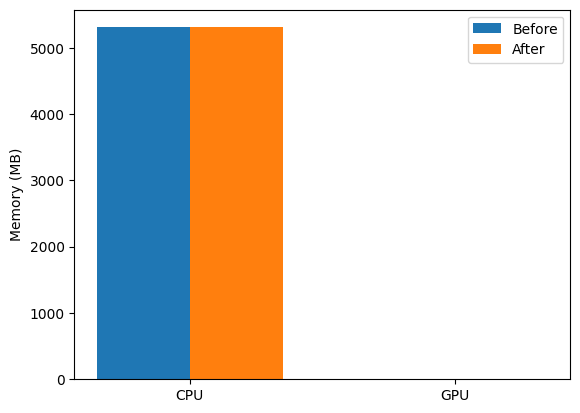

In [18]:
visualize_and_clear(fil_model)

# 4. [Whisper](https://huggingface.co/openai/whisper-large-v3) by OpenAI

In [19]:
whisper_model = whisper.load_model("large")

100%|██████████████████████████████████████| 2.88G/2.88G [00:30<00:00, 103MiB/s]


In [20]:
whisper_transcribe = whisper_model.transcribe(
    sample_audio_url,
    language="tl",
    task="transcribe"
)

whisper_translate = whisper_model.transcribe(
    sample_audio_url,
    language="tl",
    task="translate"
)

In [21]:
print("English translation:\n", whisper_translate["text"])
print("-------------------")
print("Actual Tagalog transcription:\n", df.loc[audio_idx, 'case_text'])
print("-------------------")
print("Tagalog transcription:\n", whisper_transcribe["text"])

English translation:
  I understand, ma'am. According to our system, the branch will be opened at 9 in the morning.
-------------------
Actual Tagalog transcription:
 Naiintindihan ko [eng_start/] ma'am [eng_end/] [filler/] Ayon po dito sa ating [eng_start/] system [eng_end/] [filler/] magbubukas po ang [eng_start/] branch [eng_end/] na iyan sa oras po ng alas-nueve ng umaga
-------------------
Tagalog transcription:
  Naintindihan ko, ma'am. Ayon po dito sa ating system, magbubukas po ang branch na iyan sa oras po ng alas 9 ng umaga.


In [22]:
def evaluate_whisper(df, model, overlap_thresh=0.8):
    records = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating"):
        dom  = DOMAIN_MAP.get(row['Domain'], row['Domain'])
        url  = f"{BASE_URL}/audio_samples/{dom}/{row['AudioFile']}"
        asr  = model.transcribe(url, language="tl", task="transcribe")["text"]
        trans = model.transcribe(url, task="translate")["text"]
        ref  = row['case_text']
        
        p = clean(asr)
        r = clean(ref)
        
        # perfect if substring
        if p in r or r in p:
            err = 0.0
        else:
            # or if token‐overlap ≥ threshold
            ptoks = set(p.split())
            rtoks = set(r.split())
            if ptoks and len(ptoks & rtoks) / len(ptoks) >= overlap_thresh:
                err = 0.0
            else:
                err = wer(r, p)
        
        records.append({
            "AudioFile":      url,
            "Actual":      ref,
            "Transcription":  asr,
            "Translation":    trans,
            "Cleaned Actual":      r,
            "Cleaned Transcription":  p,
            "WER":            err
        })
    
    result_df   = pd.DataFrame(records)
    overall_wer = result_df["WER"].mean()
    return result_df, overall_wer

In [23]:
whisper_df, whisper_eval = evaluate_whisper(df, whisper_model)
print("Average Word Error Rate (WER):\n", whisper_eval)
display_df(whisper_df)

Evaluating:   0%|          | 0/779 [00:00<?, ?it/s]

Average Word Error Rate (WER):
 0.3029586692501473


AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Maraming salamat sa pagtawag sa Bako ng Makati. Ako po si Teresita. Ano pong pwede may tuno pa sa inyo?,Thank you very much for calling Banko na Makati. I am Teresita. What can I ask you?,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,maraming salamat sa pagtawag sa bako ng makati ako si teresita ano pong pwede may tuno pa sa inyo,0.294118
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sa resita, may tanong lang ako tungkol sa perang nalikom ko para sa kawang gawa.",I have a question regarding the money I borrowed for the construction work.,teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,sa resita may tanong lang ako tungkol sa perang nalikom para sa kawang gawa,0.333333
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ah, ganun mo ba? Sige, sasubukan ko po kayong tulungan tungkol dyan. Maraming, maraming ko po bang matatanong muna kung may account po ba kayo sa banko? Oo, meron naman na akong account sa inyong banko.","I will try to help you with that. Can I ask if you have an account in your bank? Yes, I have an account in your bank.",ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ganun ba sige sasubukan kayong tulungan tungkol dyan maraming bang matatanong muna kung may account ba kayo sa banko oo meron naman na akong account sa inyong banko,0.714286
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,"Oo, meron naman na akong account sa inyong banko.","Yes, I already have an account in your bank.",oo meron naman na akong account sa inyong bangko,oo meron naman na akong account sa inyong banko,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]","Ah, ganun po ba? Maaari ko po bang mahini ang buong inyong pangalan? Ang pangalan ko ay Doris Kelly. Maraming salamat po. Maaari ko rin po bang mahini ang numero po ng National Insurance?",Is that so? May I ask for your full name? My name is Doris Kelly. Thank you very much. May I also ask for your National Insurance number?,ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,ganun ba maaari bang mahini ang buong inyong pangalan ang pangalan ay doris kelly maraming salamat maaari rin bang mahini ang numero ng national insurance,0.476190
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",Ang pangalan ko ay Doris Kelly.,My name is Doris Kelly.,ang pangalan ay doris kelly,ang pangalan ay doris kelly,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Ang numero ng aking national insurance ay 132-45698.,The number of my National Insurance is 132-45698.,ang numero ng aking national insurance

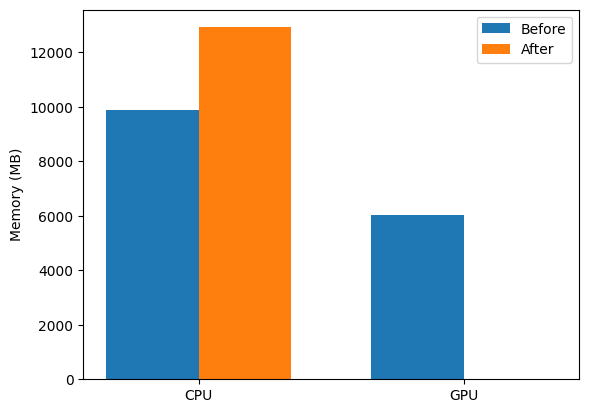

In [24]:
visualize_and_clear(whisper_model)

# 5. [Qwen/Qwen2-Audio-7B-Instruct](https://huggingface.co/Qwen/Qwen2-Audio-7B-Instruct)

### 5.1 Load the model (quantized to fit in colab T4 GPU)

In [25]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16, #bfloat16 if on ampere, lovelace, ada or hopper
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4")

qwen_processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct", sampling_rate=16000)
qwen_model = Qwen2AudioForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-Audio-7B-Instruct",
    quantization_config=quant_config,
    device_map="auto",
    )

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/638k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/853 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/79.0k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.91G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

### 5.2 Voice Chat/Audio Analysis Inference

In [26]:
qwen_conversation = [
    {'role': 'system', 'content': SYSTEM_INSTRUCTIONS},
    {"role": "user", "content": [
        {"type": "audio", "audio_url": sample_audio_url},
    ]},
    # {"role": "assistant", "content": "Yes, the speaker is female and in her twenties."},
    # {"role": "user", "content": [
    #     {"type": "audio", "audio_url": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2-Audio/audio/translate_to_chinese.wav"},
    # ]},
]


qwen_text = qwen_processor.apply_chat_template(qwen_conversation, add_generation_prompt=True, tokenize=False)
qwen_audios = []
for message in qwen_conversation:
    if isinstance(message["content"], list):
        for ele in message["content"]:
            if ele["type"] == "audio":
                qwen_audios.append(
                    librosa.load(
                        ele['audio_url'],
                        sr=qwen_processor.feature_extractor.sampling_rate
                    )[0]
                )

In [27]:
qwen_inputs = qwen_processor(text=qwen_text, audio=qwen_audios, return_tensors="pt", padding=True).to("cuda")
# qwen_inputs.input_ids = qwen_inputs.input_ids.to("cuda")

qwen_generate_ids = qwen_model.generate(**qwen_inputs, max_length=1024)
qwen_generate_ids = qwen_generate_ids[:, qwen_inputs.input_ids.size(1):]

qwen_response = qwen_processor.batch_decode(qwen_generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
display(Markdown(qwen_response))

{'language': 'Mandarin', 'sentiment': 'Neutral', 'role': 'Male', 'age_range': '26-40 years old', 'mood': 'Neutral', 'transcription': 'I am the owner of the company, I own the business, I own the branch in Espana, I also have branches in New York and Miami.', 'speech_start_time': '0.0', 'speech_end_time': '8.796'}

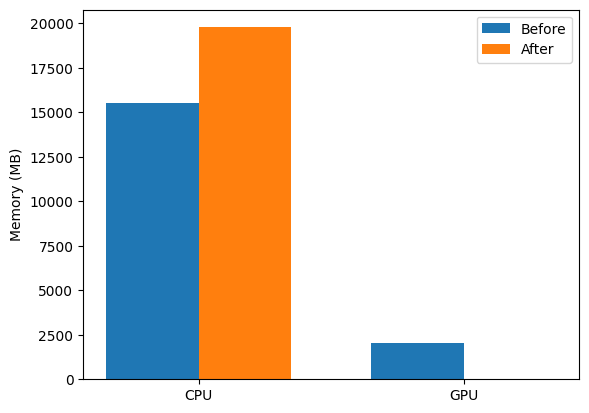

In [28]:
visualize_and_clear(qwen_model)

# 6. [fixie-ai/ultravox-v0_5-llama-3_2-1b](https://huggingface.co/fixie-ai/ultravox-v0_5-llama-3_2-1b)

In [29]:
ultravox_pipe = transformers.pipeline(model='fixie-ai/ultravox-v0_5-llama-3_2-1b', trust_remote_code=True)

config.json:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

ultravox_config.py:   0%|          | 0.00/7.06k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fixie-ai/ultravox-v0_5-llama-3_2-1b:
- ultravox_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

ultravox_pipeline.py:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

ultravox_processing.py:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fixie-ai/ultravox-v0_5-llama-3_2-1b:
- ultravox_processing.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


ultravox_model.py:   0%|          | 0.00/39.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fixie-ai/ultravox-v0_5-llama-3_2-1b:
- ultravox_model.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/fixie-ai/ultravox-v0_5-llama-3_2-1b:
- ultravox_pipeline.py
- ultravox_processing.py
- ultravox_model.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Device set to use cuda:0


In [30]:
audio, sr = librosa.load(sample_audio_url, sr=16000)
turns = [
  {
    "role": "system",
    "content": SYSTEM_INSTRUCTIONS
  },
]

In [31]:
ultravox_res = ultravox_pipe({'audio': audio, 'turns': turns, 'sampling_rate': sr}, max_new_tokens=1024)
display(Markdown(ultravox_res))

```json
{
  "language": "Filipino",
  "sentiment": "Negative",
  "role": "customer",
  "case_type": "Deposits",
  "case_transaction_type": "Inquiry",
  "case_priority_level": "Low",
  "key_themes": ["account balance", "savings account"],
  "actionable_items": ["Check customer's current balance", "Provide balance details to customer"],
  "summary": "Customer asks for their current savings account balance.",
  "problem": "Account not found"
}
```

In [32]:
def evaluate_ultravox(df, pipe, overlap_thresh=0.8, max_retries=3):
    """
    Evaluate ASR + metadata extraction from an UltraVox pipeline.

    On JSON errors:
      - if the raw output contains "personal data", skip that row entirely
      - otherwise retry up to max_retries, attempting quick fixes:
          • extract only the {...} block
          • convert stray “)”→“]”
          • remove trailing commas before } or ]
      - if still failing after max_retries, abort the whole function
    """
    records = []
    correct_ct = correct_ctx = correct_cpl = correct_role = 0
    total = len(df)

    fence_re = re.compile(r"```(?:json)?\s*(\{[\s\S]*?\})\s*```", re.DOTALL)

    for _, row in tqdm(df.iterrows(), total=total, desc="Evaluating UltraVox"):
        dom = DOMAIN_MAP.get(row["Domain"], row["Domain"])
        url = f"{BASE_URL}/audio_samples/{dom}/{row['AudioFile']}"

        audio, sr = librosa.load(url, sr=16000)
        turns = [{"role": "system", "content": SYSTEM_INSTRUCTIONS}]

        data = None
        candidate = None

        for attempt in range(1, max_retries + 1):
            raw = pipe(
                {"audio": audio, "turns": turns, "sampling_rate": sr},
                max_new_tokens=1024
            )

            # extract fenced JSON or raw
            m = fence_re.search(raw)
            candidate = m.group(1).strip() if m else raw.strip()

            # ensure we only keep the first "{" to last "}"
            idx1 = candidate.find("{")
            idx2 = candidate.rfind("}")
            if idx1 != -1 and idx2 != -1 and idx2 > idx1:
                candidate = candidate[idx1:idx2+1]

            # quick fixes
            candidate = re.sub(r"\)\s*(,|\})", r"]\1", candidate)    # stray ")" → "]"
            candidate = re.sub(r",\s*([}\]])", r"\1", candidate)    # remove trailing commas

            # try parse
            try:
                data = json.loads(candidate)
                break
            except json.JSONDecodeError as e:
                tqdm.write(f"[{attempt}/{max_retries}] JSON parse error: {e}")

                # check for personal data notice
                if "personal data" in candidate.lower():
                    tqdm.write(f"Skipping row {row['AudioFile']} due to personal data notice.")
                    display(Markdown("---"))
                    print(candidate)
                    display(Markdown("---"))
                    data = None
                    break

                # on last attempt, abort
                if attempt == max_retries:
                    tqdm.write(f"Max retries reached; Skipping row {row['AudioFile']}.")
                    display(Markdown("---"))
                    print(candidate)
                    display(Markdown("---"))
                    # raise RuntimeError(
                    #     f"Could not parse JSON for {row['AudioFile']} after {max_retries} tries."
                    # )
                    data = None
                    break
                # otherwise retry

        # if skipped for personal data, skip to next
        if data is None:
            continue

        # extract fields
        language   = data.get("language", "")
        sentiment  = data.get("sentiment", "")
        role       = data.get("role", "")
        ct_out     = data.get("case_type", "")
        ctx_out    = data.get("case_transaction_type", "")
        cpl_out    = data.get("case_priority_level", "")
        themes     = data.get("key_themes", [])
        actions    = data.get("actionable_items", [])
        summary    = data.get("summary", "")

        # update counters
        if ct_out  == row.get("case_type", ""):             correct_ct  += 1
        if ctx_out == row.get("case_transaction_type", ""): correct_ctx += 1
        if cpl_out == row.get("case_priority_level", ""):   correct_cpl += 1
        if role    == row.get("Role", ""):                  correct_role+= 1

        records.append({
            "AudioFile":             url,
            "Actual Transcription":  row["case_text"],
            "Language":              language,
            "Sentiment":             sentiment,
            "Role":                  role,
            "key_themes":            themes,
            "actionable_items":      actions,
            "summary":               summary,
            "case_type":             ct_out,
            "case_transaction_type": ctx_out,
            "case_priority_level":   cpl_out
        })

    result_df = pd.DataFrame(records)
    return (
        result_df,
        correct_ct  / total,
        correct_ctx / total,
        correct_cpl / total,
        correct_role/ total,
    )

In [33]:
ultravox_df, ultravox_type_acc, ultravox_trans_type_acc, ultravox_priority_acc, ultravox_role_acc = evaluate_ultravox(df, ultravox_pipe)

print(f"Case type accuracy: {ultravox_type_acc:.2%}")
print(f"Case transaction type accuracy: {ultravox_trans_type_acc:.2%}")
print(f"Case priority level accuracy: {ultravox_priority_acc:.2%}")
print(f"Role accuracy: {ultravox_role_acc:.2%}")

display_df(ultravox_df)

Evaluating UltraVox:   0%|          | 0/779 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[1/3] JSON parse error: Expecting value: line 1 column 1 (char 0)
[2/3] JSON parse error: Expecting value: line 1 column 1 (char 0)
[3/3] JSON parse error: Expecting value: line 1 column 1 (char 0)
Max retries reached; Skipping row sliced_audio/insurance_360108.wav.


---

```
{
  "language": "Filipino",
  "sentiment": "Neutral",
  "role": "customer",
  "case_type": "Deposits",
  "case_transaction_type": "Inquiry",
  "case_priority_level": "Medium",
  "key_themes": ["account balance", "savings account"],
  "actionable_items": [
    "Check customer's current balance",
    "Provide balance details to customer"
  ],
  "summary": "Customer asks for their current savings account balance.",
  "action": {
    "type": "email",
    "subject": "Sampungang Pagkakaisa ng Pagbabasa ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa sa Pagpapalawak ng Pagkakaisa 

---

Case type accuracy: 80.36%
Case transaction type accuracy: 39.02%
Case priority level accuracy: 27.73%
Role accuracy: 50.45%


AudioFile,Actual Transcription,Language,Sentiment,Role,key_themes,actionable_items,summary,case_type,case_transaction_type,case_priority_level
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Filipino,Negative,agent,"[bank account, mga tulong sa banko]","[Tulungan siya ng customer sa account balance, Pumunta siya sa banko para magbigay ng mga tulong]",Ang customer ay nagtanggap ng tulong sa banko na may balanse.,Deposits,Inquiry,Low
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,Filipino,Negative,customer,"[perang naliikom, kawawa gawa]","[Kung gusto mo mabuti, magpapalitan ang pera mo sa bank]",Customer wants help with their lost money.,Deposits,Inquiry,Low
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,Filipino,Negative,customer,"[account balance, savings account]",[Check customer's current balance],Customer asks if they have an account at the bank.,Deposits,Inquiry,Low
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,Filipino,Neutral,customer,"[account balance, savings account]","[Check customer's current balance, Provide balance details to customer]",Customer asks for their current savings account balance.,Deposits,Inquiry,Medium
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]",Filipino,Negative,agent,"[loan application, insurance policy]","[Verify loan application status immediately, Contact insurance provider to clarify policy details]",Agent receives inquiry about loan application and insurance policy details.,Loans,Request,High
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",English,Positive,agent,"[account balance, savings account]","[Check customer's current balance, Provide balance details to customer]",Agent responds to customer inquiry about their savings account balance.,Deposits,Inquiry,Low
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Filipino,Neutral,customer,"[account number, insurance policy]","[Verify insurance policy details with National Insurance, Contact National Insurance directly]",Customer requests verification of their insurance policy number.,Deposits,Inquiry,Medium
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328666.wav,Maraming salamat ho [n_s/] Maaari niyo rin po bang pakiberipika sa akin ang petsa ng inyong kapanganakan,Filipino,Negative,agent,"[account balance, savings account]","[Check customer's current balance, Provide balance details to customer]",Ang customer ay nagtanggap ng pagkakataon na magbigay ng balanse sa kanyang kapanganakan.,Deposits,Inquiry,Low
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328667.wav,"Ang petsa ng aking kapanganakan ay [eng_start/] ""January"" twenty-seven nineteen eighty-six [eng_end/]",Filipino,Negative,customer,"[account balance, savings account]","[Check customer's current balance, Provide balance details to customer]","Customer asked about their account ba

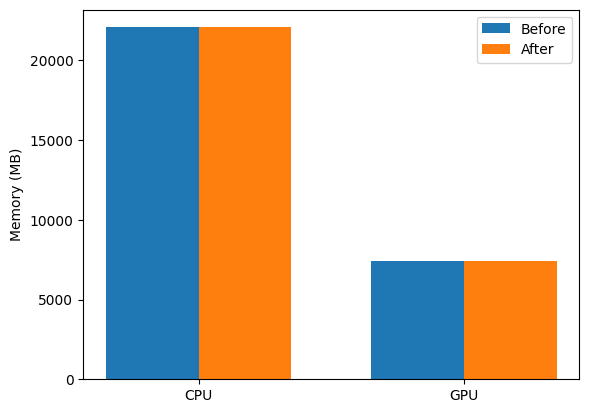

In [34]:
visualize_and_clear(ultravox_pipe)

# 6. Sample Pipeline

In [35]:
SYSTEM_INSTRUCTIONS = """
You are an AI assistant for Contact Center Operations. You will receive a single‐message audio clip—either from a customer or an agent—spoken in English, Filipino, or Taglish. Your job is to extract insights and return **only** a JSON object with the following fields and constraints:

- **language**: one of ["English", "Filipino", "Taglish"]  
- **sentiment**: one of ["Positive", "Neutral", "Negative"]  
- **role**: one of ["customer", "agent"]  
- **key_themes**: array of strings, the main topics or issues mentioned  
- **actionable_items**: array of strings, concrete next steps or tasks  
- **summary**: string, a brief human-readable synopsis  

Do **not** output any prose outside the JSON. **Only Proper JSON Format**.

### Example:

```json
{
  "language": "Filipino",
  "sentiment": "Neutral",
  "role": "customer",
  "key_themes": ["account balance", "savings account"],
  "actionable_items": ["Check customer's current balance", "Provide balance details to customer"],
  "summary": "Customer asks for their current savings account balance."
}
"""

### 6.1 Get the Audio

In [36]:
idx = 55

temp_audio, temp_audio_url = get_audio_and_path(df, idx, BANKING_PATH)
print(temp_audio_url)
temp_audio

/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_370541.wav


### 6.2 Translate and Transcribe with Whisper for more Context

In [37]:
whisper_transcribe = whisper_model.transcribe(
    temp_audio_url,
    language="tl",
    task="transcribe"
)

whisper_translate = whisper_model.transcribe(
    temp_audio_url,
    language="tl",
    task="translate"
)

display(Markdown(f"**English translation:**  \n{whisper_translate['text']}"))
display(Markdown("---"))

display(Markdown(f"**Actual Tagalog transcription:**  \n{df.loc[idx, 'case_text']}"))
display(Markdown("---"))

display(Markdown(f"**Tagalog transcription:**  \n{whisper_transcribe['text']}"))

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:124: UserWarning: Performing inference on CPU when CUDA is available
  warnings.warn("Performing inference on CPU when CUDA is available")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:124: UserWarning: Performing inference on CPU when CUDA is available
  warnings.warn("Performing inference on CPU when CUDA is available")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


**English translation:**  
 Thank you. So, two or three days. And I have a question. Will the bank be open tomorrow at bank holiday time or not?

---

**Actual Tagalog transcription:**  
[filler/] Salamat [eng_start/] so [eng_end/] dalawa o tatlong araw [filler/] at tsaka may tanong ako yung bangko ba bukas sa oras ng mga [eng_start/] bank holiday [eng_end/] o hindi

---

**Tagalog transcription:**  
 Ah, salamat. So, dalawa o tatlong araw. Eh, at saka may tanong ako, yung banko ba bukas sa oras ng mga bank holiday o hindi?

### 6.3 Use the 5 models for insights from `audio_processing.ipynb`

### 6.4 Use Ultravox for more insights

In [38]:
audio, sr = librosa.load(temp_audio_url, sr=16000)
turns = [
  {
    "role": "system",
    "content": SYSTEM_INSTRUCTIONS
  },
]
ultravox_res = ultravox_pipe({'audio': audio, 'turns': turns, 'sampling_rate': sr}, max_new_tokens=1024)
display(Markdown(ultravox_res))

```json
{
  "language": "Filipino",
  "sentiment": "Negative",
  "role": "customer",
  "key_themes": ["bank holiday", "unavailable hours"],
  "actionable_items": [
    "Ask bank about their available hours during the bank holiday"
  ],
  "summary": "Customer expresses frustration due to unavailable hours on bank holiday."
}
```